# Tile a stack of array of images into a 2D grid

In [ ]:
#| default_exp tile2d

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close
from matplotlib import pyplot as plt
from lovely_tensors import monkey_patch

In [ ]:
# |hide
monkey_patch()

In [ ]:
# |hide
# |export
from math import floor, ceil, log2

from matplotlib import colormaps
from matplotlib.colors import to_rgba, ListedColormap
import torch
from torch.nn.functional import embedding, pad

from lovely_tensors.repr_rgb import RGBProxy

## Make a bunch of cearly distinguisheable images

In [ ]:
from io import BytesIO
import math
import numpy as np

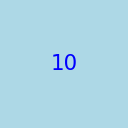

In [ ]:
number_images = []

for i in range(100):

    fig, ax = plt.subplots(figsize=(1,1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("lightblue")

    ax.spines.clear()
    ax.text(0.5, 0.5, f"{i}", va="center", ha="center", size=12, c="blue")
    fig.tight_layout(pad=0, w_pad=0, h_pad=0) # tight_layout() after we are done plotting.

        
    data_obj = BytesIO()

    fig.savefig(data_obj, format="raw", dpi=128)
    plt.close(fig)
    img_tensor = torch.tensor(np.frombuffer(data_obj.getvalue(), dtype=np.uint8))
    number_images.append(img_tensor.view(128, 128, 4).div(255)[:,:,:3].unsqueeze(0))

number_images = torch.cat(number_images)
number_images[10].rgb(cl=True)

In [ ]:
number_images

tensor[100, 128, 128, 3] n=4915200 x∈[0., 1.000] μ=0.806 σ=0.109

## Tile

In [ ]:
# |exporti

def fit_columns(t: torch.Tensor, # Tensor with images. 4-dim, ch-last: batch,y,x,ch
                view_width=966):
    """Find out how many colums and rows to use to display the images"""
    
    assert t.dim() == 4
    # Let's figure out how many images can we put in a row without the need for
    # re-scaling. Let's try to keep the number as power or 2 if we have to have
    # multiple rows.
    
    n_img = t.shape[0]
    width = t.shape[-2]
    
    n_cols = 2**floor(log2((view_width / width)))

    # At least 1 image per row, even if it does not fit the view without rescaling.
    n_cols = max(1, n_cols)

    # But if we actually don't have enough images to fill a single
    # power-of-two row, just display as many as we got.
    n_cols = min(n_img, n_cols)
    
    n_rows = ceil(n_img / n_cols) # Last row might have free space.
    
    return (n_rows, n_cols)

In [ ]:
fit_columns(number_images)

(25, 4)

In [ ]:
#| export
def tile_images(t:torch.Tensor, # Tensor containing images, 4-dim, ch-last
                view_width=966):
    """
    Tiles images in a grid that has power-of-2 columns and fits into `view_width`.
    Pad the images with a black frame and white gutters.
    """
    assert t.dim() == 4
    assert t.shape[-1] in (3, 4) # Either RGB or RGBA.

    
    n_images = t.shape[0]
    n_channels = t.shape[-1]
    xy_shape = t.shape[1:3]

    n_rows, n_cols = fit_columns(t)

    
    # We need to form the images inro a rectangular area. For this, we might
    # need to add some dummy images to the last row, whoch might be not full.
    n_extra_images = n_rows*n_cols - t.shape[0]
    if n_extra_images:
        extra_images = torch.ones((n_extra_images, *t.shape[1:]))
        t = torch.cat([ t, extra_images ])
    
    # This is where the fun begins! Imagine 't' is tensor[20, 128, 128, 3].
    # and we want 5 rows, 4 columns each.
    
    t = t.reshape(n_rows, n_cols, *t.shape[-3:])
    # Now t is tensor[5, 4, 128, 128, 3]

    t = t.permute(0, 2, 1, 3, 4)
    # now t is tensor[5, 128, 4, 128, 3]
    # If we just squick dimensions 0,1 and 2,3 togerther, we get the image we want.
    t = t.reshape(n_rows*xy_shape[0], n_cols*xy_shape[1], n_channels)
    
    # Now t is tensor[640, 512, 3], channel-last.
    
    return t

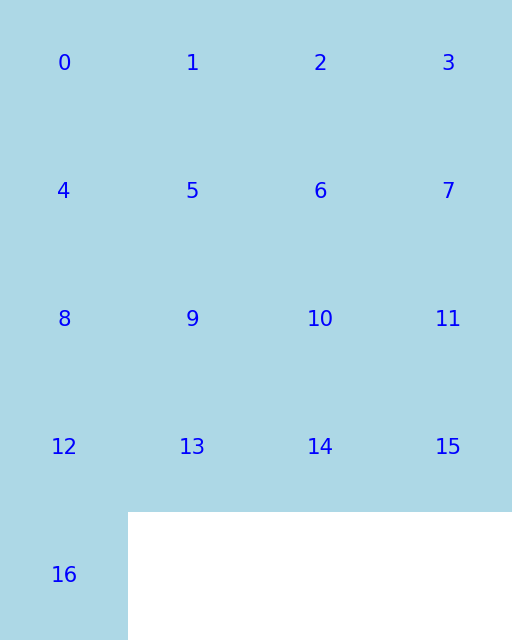

In [ ]:
tile_images(number_images[:17] ).rgb(cl=True)

In [ ]:
number_images[:17]

tensor[17, 128, 128, 3] n=835584 x∈[0., 1.000] μ=0.807 σ=0.105

In [ ]:
from lovely_tensors.pad import pad_frame_gutters

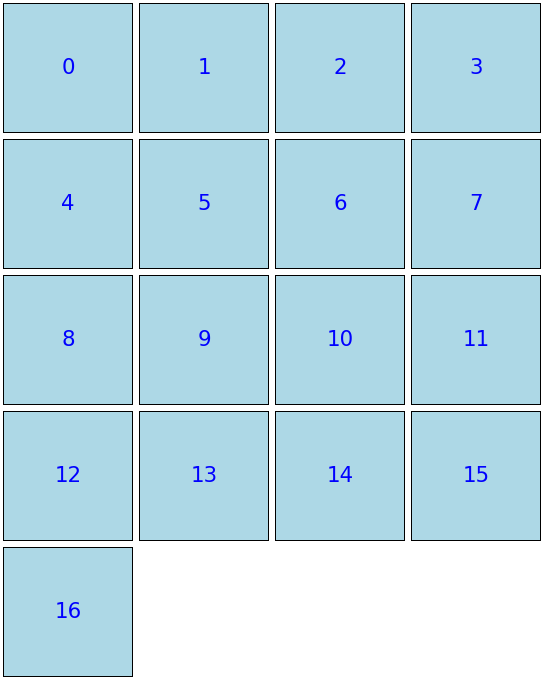

In [ ]:
tile_images(pad_frame_gutters(number_images[:17]) ).rgb(cl=True)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()